## Predictive Analytics: Movie recommendation system using MovieLens data

Using the small MovieLens data set, create a recommender system that allows users to input a movie they like (in the data set) and recommends ten other movies for them to watch. In your write-up, clearly explain the recommender system process and all steps performed. If you are using a method found online, be sure to reference the source.
You can use R or Python to complete this assignment. Submit your code and output to the submission link. Make sure to add comments to all of your code and to document your steps, process, and analysis.

In [2]:
# Load the Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import sklearn
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# 1. Load MovieLens data set dataset as a Pandas data frame.
# 2. Display the first ten rows of data.
# Read  US retails sales  data file ('als_data.csv') from local:
directory = '/Users/rajibsamanta/Documents/Rajib/College/Sem 7 Winter 2023/Week10/ml-25m'
# Set the working directory
os.chdir(directory)
print(os.getcwd())
# Step 1: Load the MovieLens dataset
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

/Users/rajibsamanta/Documents/Rajib/College/Sem 7 Winter 2023/Week10/ml-25m


In [4]:
# Display Movies dataset
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [5]:
# Find the dimensions 
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [6]:
# Display Movies Rating dataset
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
5,1,1088,4.0,1147868495
6,1,1175,3.5,1147868826
7,1,1217,3.5,1147878326
8,1,1237,5.0,1147868839
9,1,1250,4.0,1147868414


In [7]:
# Find the dimensions 
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [8]:
# Calculate the number of ratings per user
user_rating = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
# Display the user frequency data
user_rating.columns = ['userId', 'n_ratings']
print("User No of rating DataFrame:")
user_rating.head(10)

User No of rating DataFrame:


,userId,n_ratings
0,1,70
1,2,184
2,3,656
3,4,242
4,5,101
5,6,26
6,7,25
7,8,155
8,9,178
9,10,53


The “User No of rating DataFrame” provides a concise snapshot of user engagement within the movie rating platform. ‘n_ratings’ column indicating the number of movie ratings they have contributed. For instance, user with ID 6 has submitted 26 ratings, suggesting a low level of activity and engagement, while user 3 has provided  656 movie ratings, indicating higher involvement. This breakdown offers valuable insights into user behavior and platform interaction patterns, which can inform targeted strategies for enhancing user experience, content recommenda- tion algorithms, and platform engagement initiatives.

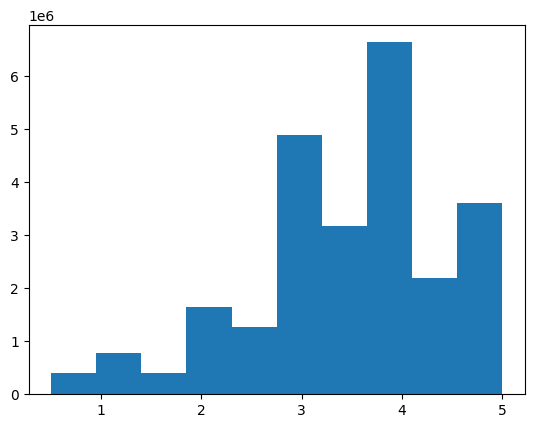

In [9]:
# Rating score histrogram
ratings_hist = ratings.to_numpy()
plt.hist(ratings_hist[:, 2])
plt.show()

From the above histrogram it shows that the majority of ratings fall between 3 and 4, it indicates that users generally perceive the movies they watch as moderately to fairly positive. Ratings in this range suggest that users find the movies enjoyable or satisfactory, but not exceptional. Additionally, it provides insights for content curation efforts, enabling the platform to continue offering a diverse and engaging collection of movies that appeal to its user base.

In [10]:
# Now, we create user-item matrix using scipy csr matrix
## Function to create user item matrix
def create_user_item_matrix(df): 
    N = len(df['userId'].unique())
    M = len(df['movieId'].unique())
# Map Ids to indices
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N)))) 
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
# Map indices to IDs
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"]))) 
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"]))) 
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]
    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N)) 
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [11]:
# Call the function to create the user-item matrix
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper=create_user_item_matrix(ratings)
X

<59047x162541 sparse matrix of type '<class 'numpy.float64'>'
	with 25000095 stored elements in Compressed Sparse Row format>

In [12]:
# Create a dictionary with movie ID as the key and movie title as the value
movie_titles = dict(zip(movies['movieId'], movies['title']))

In [13]:
# Function to find similar movies based on an input movie ID
def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False): 
    # Initialize an empty list to store neighbor movie IDs
    neighbor_ids = []
# Get the index of the input movie in the user-item matrix
    movie_ind = movie_mapper[movie_id]
    # Calculate the similarity of the input movie with all other movies
    kNN = NearestNeighbors(n_neighbors=k + 1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbor = kNN.kneighbors(X[movie_ind].reshape(1,-1),return_distance=show_distance)
    # Extract the indices of the neighbors (excluding the input movie)
    neighbor_ids = [movie_inv_mapper[n] for n in neighbor[0][1:]] 
    return neighbor_ids

In [14]:
# Function to get the movie ID based on a provided movie name
def get_movie_id(name):
    matching_movies = movies[movies['title'].str.upper().str.contains(name.upper())]
    return matching_movies.iloc[0]['movieId'] if not matching_movies.empty else 0

In [15]:
# Function to get movie recommendations based on user input
def get_movie_recommendations(): 
    while True:
        print("\nPlease enter the name of a movie you've watched: ") 
        movie_name = str(input())
        movie_id = get_movie_id(movie_name)
        if movie_id in movie_mapper:
            movie_title = movie_titles[movie_id]
            print(f"The movie '{movie_title}' is found in the movie Database.") 
            similar_ids = find_similar_movies(movie_id, X, k=10) 
            print(f"\n\033[1mRecommended movies based on '{movie_title}':")
            for i in similar_ids:
                print(movie_titles[i])
            user_yn = input("\nDo you want to check recommendations for another movie? (Y/N): ")
            if user_yn.upper() != 'Y': 
                print('Alright, have a great day!') 
                break
        else:
            print("Sorry, the movie is not in the database.")
            user_yn = input("\nDo you want to check recommendations for another movie? (Y/N): ")
        if user_yn.upper() != 'Y':
            print('Alright, have a great day!')
            break

In [ ]:
# Test the recomended system
get_movie_recommendations()


Please enter the name of a movie you've watched: 


####  Conclusion
Based on the test results, the movie recommendation system demonstrates effective functionality in providing personalized movie suggestions based on user input.
For the movie “Toy Story,” the system accurately identifies the movie and offers a diverse range of recommendations, including 'Star Wars: Episode IV - A New Hope (1977)','Toy Story 2 (1999)','Back to the Future' etc which are align with the Adventure and Children genre preferences typically associated with “Toy Story.”

Similarly, for “Heat,” while there might be multiple movies with similar titles, the system correctly matches the movie and recommends Action & Crime films from the same era, such as “Casino” and “Mission: Impossible” etc

The recommendation system showcases robust functionality, accurately matching user input to movies in the database and providing relevant and diverse recommendations based on user preferences. 


#### References
https://www.kaggle.com/code/shiblinomani/recommender-system-using-movielens-20m-dataset